In [1]:
!pip install fuzzywuzzy

In [2]:
# BLOCK 1 : Import Modules 

import os
import time

t1=time.time()

# Data Science Imports
import math
import numpy as np
import pandas as pd
from IPython.display import Markdown
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Utility Imports
from fuzzywuzzy import fuzz

# Visualization Imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [0]:
LARGE_DATASET = False

In [4]:
!git clone https://github.com/subha12k/data.git
data_path = os.path.join('/content', 'data')

Cloning into 'data'...
remote: Enumerating objects: 7, done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 7
Unpacking objects: 100% (7/7), done.


In [0]:

if LARGE_DATASET is False:
    
    movies_filename = os.path.join(data_path, 'movies.csv')
    ratings_filename = os.path.join(data_path, 'ratings.csv')
    
    df_movies = pd.read_csv(movies_filename,
                        usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})

    df_ratings = pd.read_csv(ratings_filename,
                         usecols=['userId', 'movieId', 'rating'],
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
    
else:   
    movies_filename = './ml-10M100K/movies.dat'
    ratings_filename = './ml-10M100K/ratings.dat'

    movies = pd.read_csv(movies_filename,header=None,  sep = '::')
    movies.columns = ["movieId", "title", "genre"]

    ratings = pd.read_csv(ratings_filename,header=None,  sep = '::')
    ratings.columns = ["userId", "movieId", "rating","dummy"]


    df_movies = movies[["movieId","title"]]
    df_ratings = ratings[["userId", "movieId", "rating"]]


In [6]:
# BLOCK 2 : Read In Data, Sample A Few Movies 

num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
num_ratings = len(df_ratings.rating)
print('There are {} ratings from {} unique users and {} unique movies in this data set \n'.format(num_ratings,num_users, num_items))

print(df_movies.head().to_string())
print("\n")
print(df_ratings.head().to_string())


There are 100836 ratings from 610 unique users and 9724 unique movies in this data set 

   movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)


   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


Text(0, 0.5, 'number of ratings')

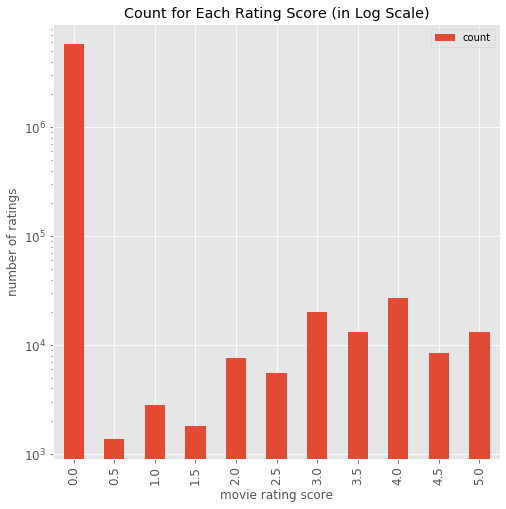

In [7]:
# BLOCK 3 : Visualise Frequency And Distribution Of Each Rating

df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])

# There are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

# Append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()

df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])

ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(8, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

Note that empty entries in the ratings matrix are assumed zero. The distribution of ratings among movies is long-tailed. That is, only a small fraction of the items are rated frequently.  This results in a highly skewed distribution of the ratings.

In [0]:
# BLOCK 4 : Write The Rating Matrix Builder

def get_rating_matrix(X):
    """Function to generate a ratings matrx and mappings for
    the user and item ids to the row and column indices

    Parameters
    ----------
    X : pandas.DataFrame, shape=(n_ratings,>=3)
        First 3 columns must be in order of user, item, rating.

    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    """
    user_col, item_col, rating_col = X.columns[:3]
    rating = X[rating_col]
    user_map = pd.Series(
        index=np.unique(X[user_col]),
        data=np.arange(X[user_col].nunique()),
        name='user_map',
    )
    item_map = pd.Series(
        index=np.unique(X[item_col]),
        data=np.arange(X[item_col].nunique()),
        name='columns_map',
    )
    user_inds = X[user_col].map(user_map)
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table(
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map

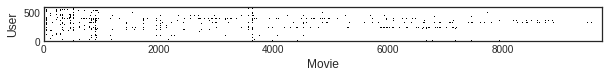

In [9]:
# BLOCK 5 : Visualise Sparsity Of Matrix

plt.rcParams["figure.figsize"] = (20,3)

rating_matrix, user_map, item_map = get_rating_matrix(df_ratings)
with plt.style.context('seaborn-white'):
    rating_matrix_binary = rating_matrix > 0
    plt.figure(figsize=(10,100))
    plt.imshow(rating_matrix_binary)
    plt.xlabel('Movie')
    plt.ylabel('User')
    plt.yscale('linear')
    plt.ylim(0,600)
    plt.show()


shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (41360, 3)


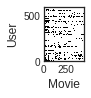

In [10]:
# BLOCK 6 : Data Reduction - Drop Movies With Less No: Of Ratings

df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

rating_matrix, user_map, item_map = get_rating_matrix(df_ratings_drop_movies)
with plt.style.context('seaborn-white'):
    rating_matrix_binary = rating_matrix > 0
    plt.figure(figsize=(1,1))
    plt.imshow(rating_matrix_binary)
    plt.xlabel('Movie')
    plt.ylabel('User')
    plt.yscale('linear')
    plt.ylim(0,600)
    plt.show()


In [11]:
# BLOCK 7: Reshape Data

# Pivot And Create Movie-User Matrix
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])

ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)

print("movie_user matrix is {}".format(movie_user_mat.head(5)))
# Create Mapper From Movie Title To Index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}

# Transform Matrix To Scipy Sparse Matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 3)
movie_user matrix is userId   1    4    6    7    15   16   17   ...  603  604  605  606  607  608  610
movieId                                     ...                                   
1        4.0  0.0  0.0  4.5  2.5  0.0  4.5  ...  4.0  3.0  4.0  2.5  4.0  2.5  5.0
2        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  5.0  3.5  0.0  0.0  2.0  0.0
3        4.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  2.0  0.0
6        4.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  4.0  3.0  0.0  0.0  0.0  0.0  5.0
7        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  2.5  0.0  0.0  0.0

[5 rows x 268 columns]


In [12]:
# BLOCK 8: Train Model

%env JOBLIB_TEMP_FOLDER=/tmp

# Define Model - The function called is imported from scikit-learn
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# model_knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=20, n_jobs=-1)
# Fit Model To Data
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [0]:
# BLOCK 9 : Define Fuzzy Matching And Make_Recommendation Functions For Movies

def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
       mapper:  dict, map movie title name to index of the movie in data
    fav_movie:  str, movie name
      verbose:  bool, print log if True

       Return:  index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations 

    Parameters
    ----------
            model_knn: knn model
                 data: movie-user ratings matrix
               mapper: dict, maps movie title name to index of the movie in the ratings matrix
            fav_movie: str, movie name
    n_recommendations: int, top n recommendations

               Return: list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))
        

In [14]:
# BLOCK 10 : Let's Make Some Recommendations!

my_favorite = 'Iron Man'
# 'Finding Nemo' 'Dark Knight' 'Avatar' 'Up' 'Inception' 'Beautiful Mind' 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)
print(f'\n Total time taken for the Recommender System to run is {time.time()-t1}')

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)']

Recommendations for Iron Man:
1: Batman Begins (2005), with distance of 0.3474416136741638
2: Sherlock Holmes (2009), with distance of 0.34635400772094727
3: Kung Fu Panda (2008), with distance of 0.3432350754737854
4: Inception (2010), with distance of 0.3307400345802307
5: District 9 (2009), with distance of 0.31877219676971436
6: Up (2009), with distance of 0.31706738471984863
7: WALL·E (2008), with distance of 0.27033132314682007
8: Avengers, The (2012), with distance of 0.26102906465530396
9: Avatar (2009), with distance of 0.25990235805511475
10: Dark Knight, The (2008), with distance of 0.24018973112106323

 Total time taken for the Recommender System to run is 11.391114950180054


KNN model recommendations above